## Data import

In [3]:
import sklearn.datasets
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from scipy import sparse
import numpy as np

rcv1 = sklearn.datasets.fetch_rcv1()

Using TensorFlow backend.


In [6]:
rcv1.data.shape

(804414, 47236)

## Data understanding

800К documents are split into 103 categories.  
Check the distribution of categories across documents

In [4]:
res = rcv1.target

cat_count = res.sum(axis=1)
one_cat = res[cat_count==1]
mult_cats = res[cat_count > 1]

In [87]:
one_cat.shape
mult_cats.shape

(1, 779809)

Check whether there is a prevalence of documents labeled with only 1 category.  Unfortunately not

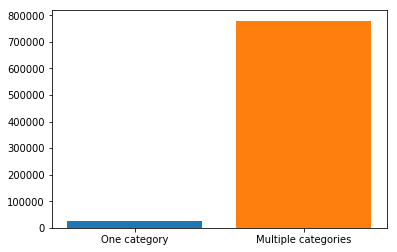

In [5]:
plt.bar("One category", one_cat.shape[1])
plt.bar("Multiple categories", mult_cats.shape[1])
plt.show()

Documents labeled with 1 category only are in the minority.  Examine the most prevalent labels

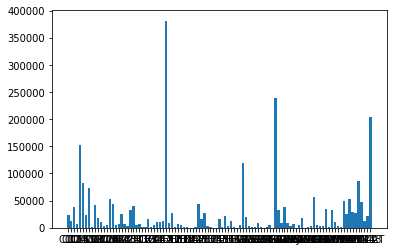

In [4]:
rcv1 = sklearn.datasets.fetch_rcv1()

res = rcv1.target

cat_sums = res.sum(axis=0).tolist()[0]
cats = rcv1.target_names.reshape(1,103).tolist()[0]

plt.bar(cats, cat_sums)

plt.show()

We see that there are 5 categories with more than 100K documents ascribed.  Let us focus on building separate binary models for each of these top 5 categories

In [196]:
biggest_cats = rcv1.target_names[(res.sum(axis=0)>100000).tolist()]

/Users/roma_koulikov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array(['C15', 'CCAT', 'ECAT', 'GCAT', 'MCAT'], dtype=object)

## Data prep

In [5]:
# split into train and test
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(rcv1.data, res)

Create function to split the data according to the top n topics

In [9]:
#
def get_top_cat_indices(target_matrix, num_cats):
    '''Returns column indices of the top n categories by number of hits'''
    cat_counts = target_matrix.sum(axis=0)
    #cat_counts = cat_counts.reshape((1,103)).tolist()[0]
    cat_counts = cat_counts.reshape((103,))
    
    ind_temp = np.argsort(-cat_counts).tolist()[0]
    
    ind = [ind_temp[i] for i in range(num_cats)]
    return ind

def prepare_data(x, y, top_cat_indices, sample_size):
    '''Returns list with train x and train y for categories specified by top_cat_indices'''
    res_lst = []

    for i in top_cat_indices:

        # get column of indices with relevant cat
        temp = y.tocsc()[:, i]
        
        bool_cat = np.where(temp.sum(axis=1)>0)[0]
        bool_noncat = np.where(temp.sum(axis=1)==0)[0]
        
        # all docs with labeled category
        cat_present = x.tocsr()[bool_cat,:]
        # all docs other than labelled category
        cat_notpresent = x.tocsr()[bool_noncat,:]
        # get indices equal to 1/2 of sample size
        idx_cat = np.random.randint(cat_present.shape[0], size=int(sample_size/2))
        idx_nocat = np.random.randint(cat_notpresent.shape[0], size=int(sample_size/2))
        # concatenate the ids
        
        sampled_x_pos = cat_present.tocsr()[idx_cat,:]
        sampled_x_neg = cat_notpresent.tocsr()[idx_nocat,:]
        sampled_x = sparse.vstack((sampled_x_pos, sampled_x_neg))
        
        sampled_y_pos = temp.tocsr()[bool_cat][idx_cat,:]
        sampled_y_neg = temp.tocsr()[bool_noncat][idx_nocat,:]            
        sampled_y = sparse.vstack((sampled_y_pos, sampled_y_neg))
        
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        sampled_y_nn = onehot_encoder.fit_transform(sampled_y.toarray())
        
        res_lst.append((sampled_x, sampled_y, sampled_y_nn))
        
    return res_lst

def prep_validation_cats(y, top_cat_indices):
    '''Returns list with arrays to be used as y argument for comparing with results.
        Leaves only the relevant category from the 103 that are in the target'''
    res_lst = []
    res_lst_nn = []
    
    for i in top_cat_indices:
        temp = y.tocsc()[:, i]
        res_lst.append(temp)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        temp_nn = onehot_encoder.fit_transform(temp.toarray())
        res_lst_nn.append(temp_nn)
    return res_lst, res_lst_nn

def build_log_models(input_list, cat_names):
    '''Builds logistic regression models from list containing tuples of x and y variables for every category being predicted'''
    model_list = []
    for i in range(len(input_list)):
        x, y, z = input_list[i]
        cat = cat_names[i]
        print("Building models for category {}".format(cat))
        model = LogisticRegression().fit(x, y.A)
        model_list.append(model)
    return(model_list)

def predict_data(model_list, test_y):
    '''Predicts using list of models and outputs tuple of precision and recall lists for every model'''
    prec_lst = []
    rec_lst = []
    for i in range(len(model_res)):
        predictions = model_list[i].predict(valid_x)
        precision = precision_score(test_y[i].A, predictions)
        prec_lst.append(precision)
        
        recall = recall_score(test_y[i].A, predictions)
        rec_lst.append(recall)
        
    return prec_lst, rec_lst

## Model-building

In [10]:
ind = get_top_cat_indices(rcv1.target, 5)
train_res = prepare_data(train_x, train_y, ind, 20000)
val_res = prep_validation_cats(valid_y, ind)

model_res = build_log_models(train_res, rcv1.target_names[ind])

Building models for category CCAT


/Users/roma_koulikov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/roma_koulikov/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Building models for category GCAT
Building models for category MCAT
Building models for category C15
Building models for category ECAT


## Predict on unseen data and examine stats

In [768]:
precision_res, recall_res = predict_data(model_res, val_res)

### Precision / recall of top 5 prevalent categories

Precision drops off by quite a bit for categories 3-5, but recall hovers at 92% mark

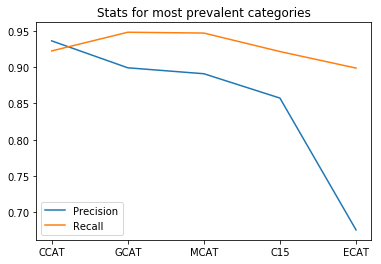

In [784]:
plt.plot(rcv1.target_names[ind], precision_res, label = 'Precision')
plt.plot(rcv1.target_names[ind], recall_res, label = 'Recall')
plt.title("Stats for most prevalent categories")
plt.plot()
plt.legend()
plt.show()

### Check natural precision in these 5 categories

Natural precision is the precision we would get if we labeled all records as belonging to the category

Text(0.5, 1.0, 'Natural precision for most prevalent categories')

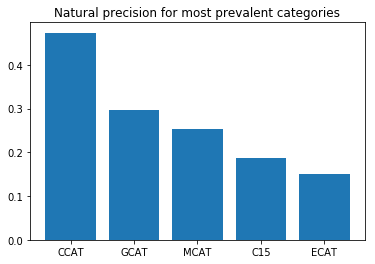

In [781]:
nat_prec = [i.nnz/i.shape[0] for i in val_res]
plt.bar(rcv1.target_names[ind], nat_prec)
plt.title("Natural precision for most prevalent categories")

### Lift over natural precision 

Interestingly enough, we see that the lift over natural precision actually increases as we go from the 
most prevalent to less prevalent categories

In [758]:
lift = [prediction_res[i]/nat_prec[i] for i in range(len(prediction_res))]

Text(0.5, 1.0, 'Lift over natural precision for most prevalent categories')

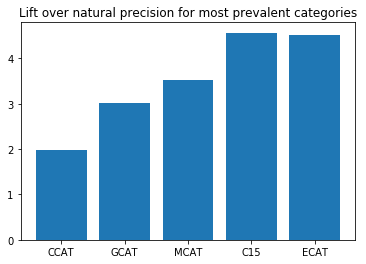

In [759]:
plt.bar(rcv1.target_names[ind], lift)
plt.title("Lift over natural precision for most prevalent categories")

## Thoughts on refinement

Potential for improvement:
    - Build models on cross-validated data
    - Experiment with different algorithms and tuning (ex. Naive Bayes, Random Forest, XGBoost).  I did build an an analogous model using a 3-layer NN.  But, Jupyter notebook kept crashing every time I attempted to run it.  Thus, I put it into a separate script.  Alas, the metrics are very similar to what we see for logistic regression.  Check the nn_res.png chart in the parent directory.  The code is in main.py
    - Build model on word embeddings.  This, however, would require a different version of the RCV! dataset, as the scikit-learn version has already been pre-processed into a tfidf.